# Import Libraries

In [1]:
from datasets import load_dataset, Dataset as hugging_dataset_cls
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Literal
from PIL import Image

# Import Data

In [2]:
# Load the emoji dataset
dataset = load_dataset("valhalla/emoji-dataset")

# Check the data
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 2749
    })
})


# Plot Examples

In [3]:
# Parse features and labels
images = dataset['train']['image']
text = dataset['train']['text']


# Prepare Dataset

## Train Val Test Split

In [4]:
# NOTE if it ain't broke ...
fltr = lambda x: "face" in x['text'] and \
                "clock" not in x['text'] and \
                "woman" not in x['text'] and \
                "man" not in x['text'] and \
                "face palm" not in x['text'] and \
                "monkey face" not in x['text'] and \
                "dog face" not in x['text'] and \
                "wolf face" not in x['text'] and \
                "fox face" not in x['text'] and \
                "cat face" not in x['text'] and \
                "lion face" not in x['text'] and \
                "tiger face" not in x['text'] and \
                "horse face" not in x['text'] and \
                "unicorn face" not in x['text'] and \
                "zebra face" not in x['text'] and \
                "cow face" not in x['text'] and \
                "pig face" not in x['text'] and \
                "face throwing a kiss" not in x['text'] and \
                "giraffe face" not in x['text'] and \
                "mouse face" not in x['text'] and \
                "hamster face" not in x['text'] and \
                "rabbit face" not in x['text'] and \
                "bear face" not in x['text'] and \
                "panda face" not in x['text'] and \
                "frog face" not in x['text'] and \
                "dragon face" not in x['text'] and \
                "face massage" not in x['text'] and \
                "person with pouting face" not in x['text'] and \
                "face with no good gesture" not in x['text'] and \
                "face with ok gesture" not in x['text'] and \
                "new moon with face" not in x['text'] and \
                "first quarter moon with face" not in x['text'] and \
                "last quarter moon with face" not in x['text'] and \
                "full moon with face" not in x['text'] and \
                "sun with face" not in x['text'] and \
                "wind blowing face" not in x['text']

faces_dataset = dataset['train'].filter(fltr)
faces_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 90
})

The Filtered Dataset:


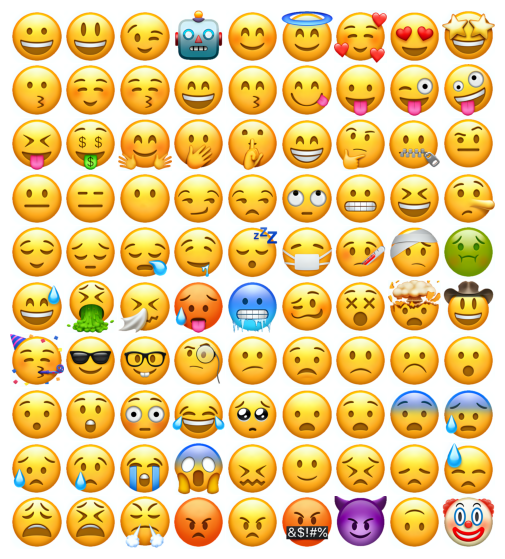

In [5]:
from mpl_toolkits.axes_grid1 import ImageGrid

def view_data(images):
    fig = plt.figure(figsize=(7., 7.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(10, 9),  # creates 2x2 grid of Axes
                    axes_pad=0.01,  # pad between Axes in inch.
                    )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.axis('off')

    print(f'The Filtered Dataset:')
    plt.show()

filtered_images = faces_dataset['image']
filtered_text = faces_dataset['text']

view_data(images=filtered_images)

## Augment Dataset
We augment the dataset by greating a hundred copies of each image, perturbed by Gaussian noise

Dataset({
    features: ['image', 'text'],
    num_rows: 900
})

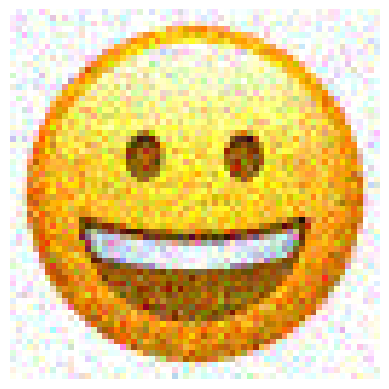

In [6]:
from torchvision.transforms import v2

to_tensor = transforms.ToTensor()
example_im = to_tensor(filtered_images[0].resize((64,64))).permute(1,2,0)
noisify = v2.GaussianNoise()
plt.imshow(noisify(example_im))
plt.axis('off')
# plt.show()

temp1, temp2 = [], []
for im, text in zip(faces_dataset['image'], faces_dataset['text']):
    for _ in range(10):
        noisy_im = noisify(to_tensor(im.resize((64,64))).permute(1,2,0))
        temp1.append(noisy_im)
        temp2.append(text)
# print(temp1)
augmented_dataset=  {'image':np.array(temp1), 'text':np.array(temp2)}
augmented_dataset = hugging_dataset_cls.from_dict(augmented_dataset)
augmented_dataset

In [214]:
temp1, temp2 = [], []
for emoji_index, [im, text] in enumerate(zip(faces_dataset['image'], faces_dataset['text'])):
    for _ in range(10):
        noisy_im = noisify(to_tensor(im.resize((64,64))).permute(1,2,0))

        # NOTE Dan will hate these two lines
        if emoji_index in (3, 44, 48, 49, 70, 71, 75, 84, 86, 87, 89): conditional = [0,1]
        else: conditional = [1,0]

        temp1.append(noisy_im)
        temp2.append(conditional)

augmented_conditional_dataset=  {'image':np.array(temp1), 'text':np.array(temp2)}
augmented_conditional_dataset = hugging_dataset_cls.from_dict(augmented_conditional_dataset)
augmented_conditional_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 900
})

In [7]:
# temp = []
# for i in range(90):
#     im = to_tensor(np.array(augmented_dataset['image'][i])).permute(1,2,0)
#     temp.append(im)
# view_data(images=temp)

In [215]:
def split(dataset):
    train_test = dataset.train_test_split(test_size=0.2)
    train_val = train_test['train'].train_test_split(test_size=0.25)
    dataset_split = {
        'train': train_val['train'],
        'val': train_val['test'],
        'test': train_test['test']
    }
    return dataset_split

# not augmented for baseline!
# dataset_split = split(dataset = faces_dataset)

# augmented for Question 1!
# dataset_split = split(dataset = augmented_dataset)

# augmented and conditional for Question 2!
dataset_split = split(dataset = augmented_conditional_dataset)

In [9]:
dataset_split['train']

Dataset({
    features: ['image', 'text'],
    num_rows: 540
})

## Create Custom Dataset

In [ ]:
class EmojiDataset(Dataset):
    def __init__(self, data: hugging_dataset_cls, cond=False):
        self.X = data['image']
        self.y = data['text']
        # self.data = data
        # self.y = data['image']

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        to_tensor = transforms.ToTensor()
        # img_X = to_tensor(self.X[idx]).reshape(-1)
        # img_y = to_tensor(self.X[idx]).reshape(-1)
        img_X = to_tensor(np.array(self.X[idx], dtype=np.float32)).reshape(-1)
        img_y = to_tensor(np.array(self.X[idx], dtype=np.float32)).reshape(-1)
        return img_X, img_y

## Create Dataset Objects

In [11]:
train_ds = EmojiDataset(dataset_split['train'])
val_ds = EmojiDataset(dataset_split['val'])
test_ds = EmojiDataset(dataset_split['test'])

## Batch into DataLoaders

In [12]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

for batch_X, batch_y in train_loader:
    print(batch_X.shape)
    print(batch_y.shape)
    example_im = batch_X[0]
    print(type(example_im))
    print(example_im.shape)
    example_im = example_im.reshape(3,64,64)

    break

torch.Size([8, 12288])
torch.Size([8, 12288])
<class 'torch.Tensor'>
torch.Size([12288])


# Create Autoencoder

In [16]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64*64*3, 64*64),
            nn.LeakyReLU(),
            nn.Linear(64*64, 16*64),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16*64, 64*64),
            nn.LeakyReLU(),
            nn.Linear(64*64, 64*64*3),
            nn.Sigmoid()
        )

    def forward(self, X):
        x = self.encoder(X)
        return self.decoder(x)

# Train Model

## Create Trainer

In [17]:
class Trainer:
    def __init__(self, model: nn.Module, optimizer: optim.Optimizer, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader, test_loader: DataLoader, loss_fn: nn.MSELoss = nn.MSELoss()):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.n_epochs = n_epochs
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

    def train(self):
        train_losses, val_losses = [], []
        for epoch in range(1, self.n_epochs+1):
            print(f"Epoch {epoch}/{self.n_epochs}:")
            train_epoch_loss = self._train_single_epoch()
            val_epoch_loss = self._valid_single_epoch(self.val_loader)
            train_losses.append(train_epoch_loss)
            val_losses.append(val_epoch_loss)
            print("\n")

        return {
            "train_losses": train_losses,
            "val_losses": val_losses
        }
    
    def evaluate(self, loader_type: Literal['validation', 'test']) -> float:
        if loader_type == "test":
            loader = self.test_loader
        else:
            loader = self.val_loader

        return self._valid_single_epoch(loader, label=loader_type.capitalize())

    def _train_single_epoch(self) -> float:
        self.model.train()
        running_loss = 0.0
        pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader))
        for i, (input_data, output_data) in pbar:
            batch_num = i+1
            # Zero out grads
            self.optimizer.zero_grad()

            # Forward pass
            output = self.model(input_data)
            loss = self.loss_fn(output, output_data)
            running_loss += loss.item()

            # Backward pass
            loss.backward()
            self.optimizer.step()

            # Log
            avg_loss = running_loss / batch_num
            pbar.set_description(f"Avg Train Loss: {avg_loss:.4f}")

        return avg_loss
    
    @torch.no_grad()
    def _valid_single_epoch(self, loader: DataLoader, label: str = "Validation") -> float:
        self.model.eval()
        running_loss = 0.0
        pbar = tqdm(enumerate(loader), total=len(loader))
        for i, (input_data, output_data) in pbar:
            batch_num = i+1
            # Forward pass
            output = self.model(input_data)
            loss = self.loss_fn(output, output_data)
            running_loss += loss.item()

            # Log
            avg_loss = running_loss / batch_num
            pbar.set_description(f"Avg {label} Loss: {avg_loss:.4f}")

        return avg_loss

## Train

In [18]:
model = AutoEncoder()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    n_epochs=25,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)

history = trainer.train()

Epoch 1/25:


Avg Validation Loss: 0.0948: 100%|██████████| 23/23 [00:00<00:00, 33.60it/s]




Epoch 2/25:


Avg Validation Loss: 0.0948: 100%|██████████| 23/23 [00:00<00:00, 33.57it/s]




Epoch 3/25:


Avg Validation Loss: 0.0946: 100%|██████████| 23/23 [00:00<00:00, 33.14it/s]




Epoch 4/25:


Avg Validation Loss: 0.0946: 100%|██████████| 23/23 [00:00<00:00, 32.20it/s]




Epoch 5/25:


Avg Validation Loss: 0.0946: 100%|██████████| 23/23 [00:00<00:00, 32.48it/s]




Epoch 6/25:


Avg Train Loss: 0.0957:  90%|████████▉ | 61/68 [00:13<00:01,  4.46it/s]


KeyboardInterrupt: 

## Plot Training

In [ ]:
train_losses = history['train_losses']
val_losses = history['val_losses']
plt.title("Losses by Epoch")
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valdiation Loss')
plt.legend()
plt.show()

In [ ]:
@torch.no_grad()
def plot_input_output(model):
    i = 0
    final = []
    for batch_X, batch_y in val_loader:
        test_im = batch_X[i]
        pred_test_im = model(test_im)


        test_im = torch.rot90(test_im.reshape(3,64,64), dims=(1,2))
        pred_test_im = torch.rot90(pred_test_im.reshape(3,64,64), dims=(1,2))

        final.append(torch.hstack((test_im, pred_test_im)).permute(2,1,0))
        i += 1
        if i >= 5: break

    render = torch.vstack(final)
    plt.imshow(render)
    plt.title(f' Input     Output') # TODO excellent solution! never fix
    plt.axis("off")
    plt.show()

plot_input_output(model=model)

## Try Convolutional Architecture

In [67]:
class AutoEncoderCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Flatten(),
            nn.Linear(1352, 512),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(512, 64*64),
            nn.LeakyReLU(),
            nn.Linear(64*64, 64*64*3),
            nn.Sigmoid()
        )

    def forward(self, X):
        z = self.encoder(X)
        return self.decoder(z)

modelCNN = AutoEncoderCNN()
for batch_X, batch_y in train_loader_cnn:
    z = modelCNN.encoder(batch_X)
    # print(z)
    print(f'Latent dimension: {z.shape}')
    y = modelCNN.decoder(z)
    # print(y)
    print(f'Final output dimension: {y.shape}')

    break

Latent dimension: torch.Size([8, 512])
Final output dimension: torch.Size([8, 12288])


In [184]:
class EmojiDatasetCNN(Dataset):
    def __init__(self, data: hugging_dataset_cls, cond=False):
        self.data = data
        self.X = data['image']
        self.y = data['text']
        self.cond = cond

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        to_tensor = transforms.ToTensor()
        # img_X = to_tensor(self.X[idx])
        # img_y = to_tensor(self.y[idx]).reshape(-1)
        img_X = to_tensor(np.array(self.X[idx], dtype=np.float32))
        if self.cond: img_y = [to_tensor(np.array(self.X[idx], dtype=np.float32)).reshape(-1), self.y[idx]]
        else: img_y = to_tensor(np.array(self.X[idx], dtype=np.float32)).reshape(-1)
        return img_X, img_y

train_ds_cnn = EmojiDatasetCNN(dataset_split['train'])
val_ds_cnn = EmojiDatasetCNN(dataset_split['val'])
test_ds_cnn = EmojiDatasetCNN(dataset_split['test'])

train_loader_cnn = DataLoader(train_ds_cnn, batch_size=8, shuffle=True)
val_loader_cnn = DataLoader(val_ds_cnn, batch_size=8, shuffle=False)
test_loader_cnn = DataLoader(test_ds_cnn, batch_size=8, shuffle=False)

for batch_X, batch_y in train_loader_cnn:
    print(batch_X.shape)
    print(batch_y.shape)
    break


torch.Size([8, 3, 64, 64])
torch.Size([8, 12288])


In [68]:
optimizer = optim.Adam(modelCNN.parameters(), lr=1e-3)
trainer = Trainer(
    model=modelCNN,
    optimizer=optimizer,
    n_epochs=15,
    train_loader=train_loader_cnn,
    val_loader=val_loader_cnn,
    test_loader=test_loader_cnn
)

history_cnn = trainer.train()

Epoch 1/15:


Avg Validation Loss: 0.0296: 100%|██████████| 23/23 [00:00<00:00, 42.20it/s]




Epoch 2/15:


Avg Validation Loss: 0.0272: 100%|██████████| 23/23 [00:00<00:00, 39.13it/s]




Epoch 3/15:


Avg Validation Loss: 0.0241: 100%|██████████| 23/23 [00:00<00:00, 41.50it/s]




Epoch 4/15:


Avg Validation Loss: 0.0197: 100%|██████████| 23/23 [00:00<00:00, 43.18it/s]




Epoch 5/15:


Avg Validation Loss: 0.0164: 100%|██████████| 23/23 [00:00<00:00, 42.43it/s]




Epoch 6/15:


Avg Validation Loss: 0.0137: 100%|██████████| 23/23 [00:00<00:00, 41.23it/s]




Epoch 7/15:


Avg Validation Loss: 0.0120: 100%|██████████| 23/23 [00:00<00:00, 40.30it/s]




Epoch 8/15:


Avg Validation Loss: 0.0104: 100%|██████████| 23/23 [00:00<00:00, 42.38it/s]




Epoch 9/15:


Avg Validation Loss: 0.0095: 100%|██████████| 23/23 [00:00<00:00, 41.09it/s]




Epoch 10/15:


Avg Validation Loss: 0.0091: 100%|██████████| 23/23 [00:00<00:00, 42.96it/s]




Epoch 11/15:


Avg Validation Loss: 0.0085: 100%|██████████| 23/23 [00:00<00:00, 38.25it/s]




Epoch 12/15:


Avg Validation Loss: 0.0080: 100%|██████████| 23/23 [00:00<00:00, 40.28it/s]




Epoch 13/15:


Avg Validation Loss: 0.0079: 100%|██████████| 23/23 [00:00<00:00, 42.72it/s]




Epoch 14/15:


Avg Validation Loss: 0.0078: 100%|██████████| 23/23 [00:00<00:00, 38.09it/s]




Epoch 15/15:


Avg Validation Loss: 0.0077: 100%|██████████| 23/23 [00:00<00:00, 40.52it/s]

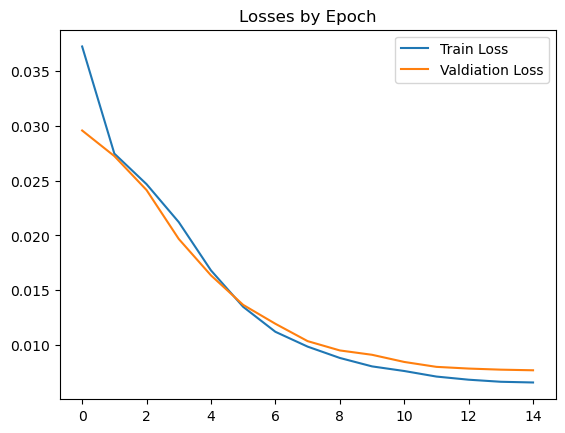

Avg test Loss: 0.0078: 100%|██████████| 23/23 [00:00<00:00, 38.54it/s]


0.007772103154464909

In [141]:
train_losses = history_cnn['train_losses']
val_losses = history_cnn['val_losses']
plt.title("Losses by Epoch")
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valdiation Loss')
plt.legend()
plt.show()

trainer._valid_single_epoch(loader=test_loader_cnn, label='test')


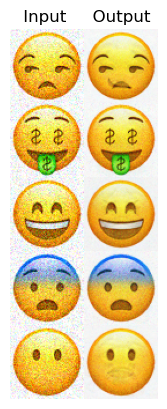

In [77]:
@torch.no_grad()
def plot_input_output(model):
    for batch_X, batch_y in val_loader_cnn:
        test_im = batch_X[:5]
        pred_test_im = model(test_im).reshape(5,3,64,64)
        final = []
        for i in range(5):
            thing = torch.hstack((torch.rot90(test_im[i], dims=(1,2)), torch.rot90(pred_test_im[i], dims=(1,2)))).permute(2,1,0)
            final.append(thing)

        render = torch.vstack(final)
        plt.imshow(render)
        plt.title(f' Input     Output') # TODO excellent solution! never fix
        plt.axis("off")
        plt.show()
        break

plot_input_output(model=modelCNN)

## Latent Math (Question 3)

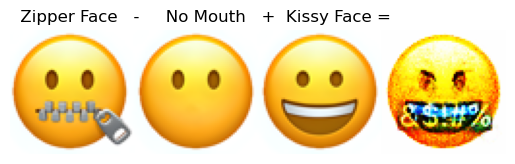

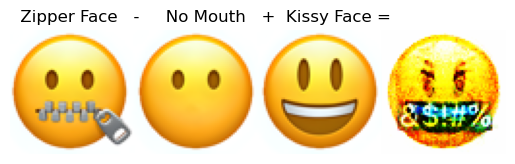

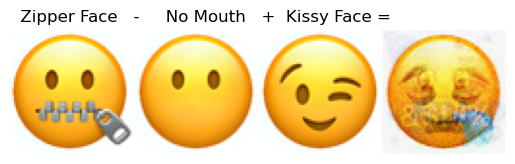

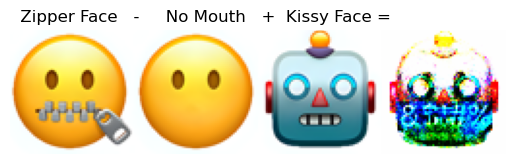

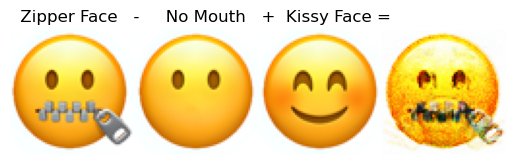

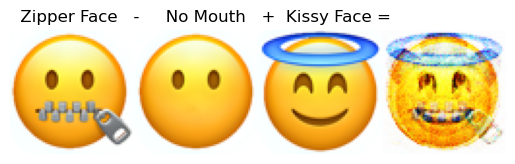

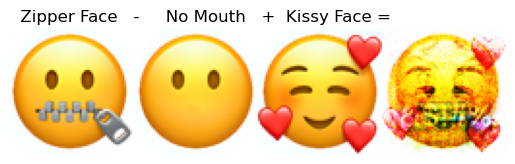

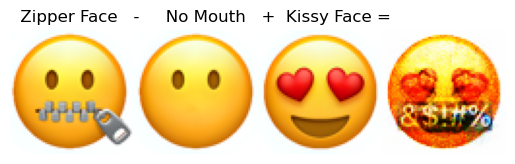

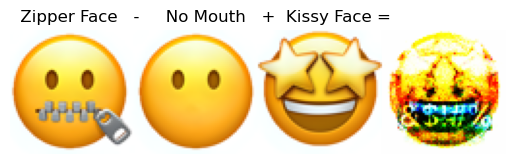

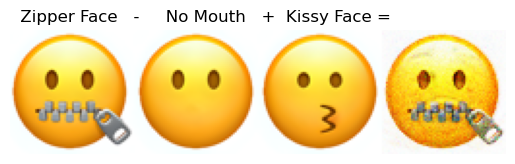

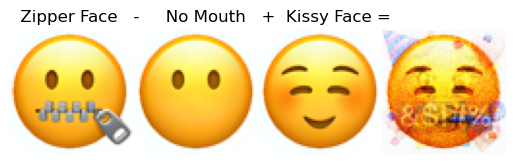

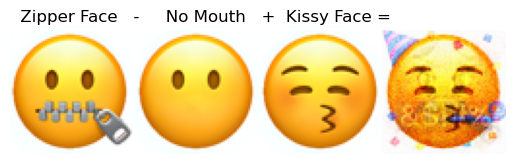

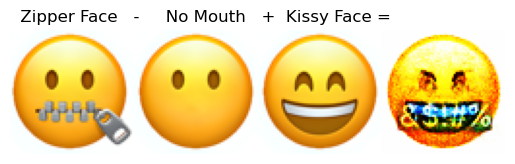

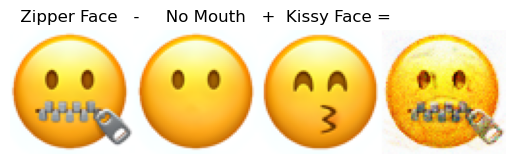

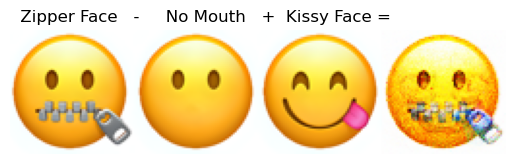

In [140]:
# 5 - 4 + 7
@torch.no_grad()
def add_halo(im_index):
    emoji_5 = to_tensor(filtered_images[5].resize((64,64))).permute(1,2,0)
    emoji_4 = to_tensor(filtered_images[4].resize((64,64))).permute(1,2,0)
    emoji_7 = to_tensor(filtered_images[im_index].resize((64,64))).permute(1,2,0)
    batch_emoji_ims = torch.tensor(np.array([emoji_5, emoji_4, emoji_7])).permute(0,3,1,2)
    batch_emoji_latents = modelCNN.encoder(batch_emoji_ims)
    gen_latent = batch_emoji_latents[0] - batch_emoji_latents[1] + batch_emoji_latents[2]
    im = modelCNN.decoder(gen_latent)
    im = im.reshape(3,64,64).permute(1,2,0)
    final = torch.hstack((emoji_5, emoji_4, emoji_7, im))
    plt.imshow(final)
    plt.title(f' Halo Smile   -       Smile       +    Big Smile =                   ') # TODO excellent solution! never fix
    plt.axis("off")
    plt.show()

@torch.no_grad()
def add_zipper(im_index):
    emoji_5 = to_tensor(filtered_images[25].resize((64,64))).permute(1,2,0)
    emoji_4 = to_tensor(filtered_images[29].resize((64,64))).permute(1,2,0)
    emoji_7 = to_tensor(filtered_images[im_index].resize((64,64))).permute(1,2,0)
    batch_emoji_ims = torch.tensor(np.array([emoji_5, emoji_4, emoji_7])).permute(0,3,1,2)
    batch_emoji_latents = modelCNN.encoder(batch_emoji_ims)
    gen_latent = 1.5*(batch_emoji_latents[0] - batch_emoji_latents[1]) + batch_emoji_latents[2]
    im = modelCNN.decoder(gen_latent)
    im = im.reshape(3,64,64).permute(1,2,0)
    final = torch.hstack((emoji_5, emoji_4, emoji_7, im))
    plt.imshow(final)
    plt.title(f' Zipper Face   -     No Mouth   +  Kissy Face =                     ') # TODO excellent solution! never fix
    plt.axis("off")
    plt.show()

for index in range(15):
    # add_halo(im_index=index)
    add_zipper(im_index=index)

## Training with a Classification Side-Objective (Question 2)

In [230]:
class TrainerCond:
    def __init__(self, model: nn.Module, optimizer: optim.Optimizer, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader, test_loader: DataLoader, loss_fn: nn.MSELoss = nn.MSELoss(), loss_fn_cond: nn.BCELoss = nn.BCELoss()):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_fn_cond = loss_fn_cond
        self.n_epochs = n_epochs
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.lam = 0.5

    def train(self):
        train_losses, val_losses = [], []
        train_losses_im, val_losses_im = [], []
        train_losses_cond, val_losses_cond = [], []
        for epoch in range(1, self.n_epochs+1):
            print(f"Epoch {epoch}/{self.n_epochs}:")
            train_epoch_loss, train_epoch_loss_im, train_epoch_loss_cond = self._train_single_epoch()
            val_epoch_loss, val_epoch_loss_im, val_epoch_loss_cond = self._valid_single_epoch(self.val_loader)
            train_losses.append(train_epoch_loss)
            val_losses.append(val_epoch_loss)
            train_losses_im.append(train_epoch_loss_im)
            val_losses_im.append(val_epoch_loss_im)
            train_losses_cond.append(train_epoch_loss_cond)
            val_losses_cond.append(val_epoch_loss_cond)
            print("\n")

        return {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_losses_im": train_losses_im,
            "val_losses_im": val_losses_im,
            "train_losses_cond": train_losses_cond,
            "val_losses_cond": val_losses_cond
        }
    
    def evaluate(self, loader_type: Literal['validation', 'test']) -> float:
        if loader_type == "test":
            loader = self.test_loader
        else:
            loader = self.val_loader

        return self._valid_single_epoch(loader, label=loader_type.capitalize())

    def _train_single_epoch(self) -> float:
        self.model.train()
        running_loss = 0.0
        running_loss_im = 0.0
        running_loss_cond = 0.0
        
        pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader))
        for i, (input_data, output_data) in pbar:
            output_data, cond = output_data
            batch_num = i+1
            # Zero out grads
            self.optimizer.zero_grad()

            # Forward pass
            output = self.model(input_data)

            cond = torch.transpose(torch.tensor(np.array(cond)).type(torch.float32), 0, 1)

            loss_im = self.loss_fn(output[:, :-2], output_data) 
            loss_cond = self.loss_fn_cond(output[:, -2:], cond)
            loss = loss_im + self.lam * loss_cond
            running_loss_im += loss_im.item()
            running_loss_cond += loss_cond.item()
            running_loss += loss.item()

            # Backward pass
            loss.backward()
            self.optimizer.step()

            # Log
            avg_loss_im = running_loss_im / batch_num
            avg_loss_cond = running_loss_cond / batch_num
            avg_loss = running_loss / batch_num
            pbar.set_description(f"Avg Train Loss: {avg_loss:.4f}")

        return avg_loss, avg_loss_im, avg_loss_cond
    
    @torch.no_grad()
    def _valid_single_epoch(self, loader: DataLoader, label: str = "Validation") -> float:
        self.model.eval()
        running_loss = 0.0
        running_loss_im = 0.0
        running_loss_cond = 0.0
        pbar = tqdm(enumerate(loader), total=len(loader))
        for i, (input_data, output_data) in pbar:
            output_data, cond = output_data
            batch_num = i+1
            # Forward pass
            output = self.model(input_data)
            cond = torch.transpose(torch.tensor(np.array(cond)).type(torch.float32), 0 ,1)
            loss_im = self.loss_fn(output[:, :-2], output_data) 
            loss_cond = self.loss_fn_cond(output[:, -2:], cond)
            loss = loss_im + self.lam * loss_cond
            running_loss_im += loss_im.item()
            running_loss_cond += loss_cond.item()
            running_loss += loss.item()

            # Log
            avg_loss_im = running_loss_im / batch_num
            avg_loss_cond = running_loss_cond / batch_num
            avg_loss = running_loss / batch_num
            pbar.set_description(f"Avg {label} Loss: {avg_loss:.4f}")

        return avg_loss, avg_loss_im, avg_loss_cond

In [216]:
# NOTE dan please dont kill me

train_ds_cnn_cond = EmojiDatasetCNN(dataset_split['train'], cond=True)
val_ds_cnn_cond = EmojiDatasetCNN(dataset_split['val'], cond=True)
test_ds_cnn_cond = EmojiDatasetCNN(dataset_split['test'], cond=True)

train_loader_cnn_cond = DataLoader(train_ds_cnn_cond, batch_size=8, shuffle=True)
val_loader_cnn_cond = DataLoader(val_ds_cnn_cond, batch_size=8, shuffle=False)
test_loader_cnn_cond = DataLoader(test_ds_cnn_cond, batch_size=8, shuffle=False)

for batch_X, batch_y in train_loader_cnn_cond:
    print(batch_y)
    batch_y, cond = batch_y
    print(batch_X.shape)
    print(batch_y.shape)
    print(cond)
    break



[tensor([[1.0000, 0.9093, 0.9473,  ..., 1.0000, 0.8962, 1.0000],
        [0.9260, 1.0000, 0.8131,  ..., 0.8364, 0.9500, 1.0000],
        [0.9101, 1.0000, 0.9347,  ..., 1.0000, 1.0000, 0.8887],
        ...,
        [1.0000, 0.9876, 0.8378,  ..., 0.9518, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9316],
        [1.0000, 0.9211, 0.9800,  ..., 1.0000, 0.8646, 0.8671]]), [tensor([1, 1, 0, 1, 1, 1, 1, 0]), tensor([0, 0, 1, 0, 0, 0, 0, 1])]]
torch.Size([8, 3, 64, 64])
torch.Size([8, 12288])
[tensor([1, 1, 0, 1, 1, 1, 1, 0]), tensor([0, 0, 1, 0, 0, 0, 0, 1])]


In [226]:
class AutoEncoderCNNcond(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Flatten(),
            nn.Linear(1352, 512),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(512, 64*64),
            nn.LeakyReLU(),
            nn.Linear(64*64, 64*64*3 + 2),
            nn.Sigmoid()
        )

    def forward(self, X):
        z = self.encoder(X)
        return self.decoder(z)

modelCNNcond = AutoEncoderCNNcond()
for batch_X, batch_y in train_loader_cnn_cond:
    z = modelCNN.encoder(batch_X)
    print(f'Latent dimension: {z.shape}')
    y = modelCNN.decoder(z)
    print(f'Final output dimension: {y.shape}')

    break

Latent dimension: torch.Size([8, 512])
Final output dimension: torch.Size([8, 12289])


In [231]:
optimizer = optim.Adam(modelCNNcond.parameters(), lr=1e-3)
trainer = TrainerCond(
    model=modelCNNcond,
    optimizer=optimizer,
    n_epochs=15,
    train_loader=train_loader_cnn_cond,
    val_loader=val_loader_cnn_cond,
    test_loader=test_loader_cnn_cond
)

history_cnn = trainer.train()

Epoch 1/15:


Avg Validation Loss: 0.0356: 100%|██████████| 23/23 [00:00<00:00, 38.25it/s]




Epoch 2/15:


Avg Validation Loss: 0.0261: 100%|██████████| 23/23 [00:00<00:00, 38.99it/s]




Epoch 3/15:


Avg Validation Loss: 0.0223: 100%|██████████| 23/23 [00:00<00:00, 40.06it/s]




Epoch 4/15:


Avg Validation Loss: 0.0180: 100%|██████████| 23/23 [00:00<00:00, 42.78it/s]




Epoch 5/15:


Avg Validation Loss: 0.0155: 100%|██████████| 23/23 [00:00<00:00, 41.52it/s]




Epoch 6/15:


Avg Validation Loss: 0.0138: 100%|██████████| 23/23 [00:00<00:00, 42.21it/s]




Epoch 7/15:


Avg Validation Loss: 0.0123: 100%|██████████| 23/23 [00:00<00:00, 42.87it/s]




Epoch 8/15:


Avg Validation Loss: 0.0115: 100%|██████████| 23/23 [00:00<00:00, 42.43it/s]




Epoch 9/15:


Avg Validation Loss: 0.0107: 100%|██████████| 23/23 [00:00<00:00, 41.77it/s]




Epoch 10/15:


Avg Validation Loss: 0.0099: 100%|██████████| 23/23 [00:00<00:00, 40.59it/s]




Epoch 11/15:


Avg Validation Loss: 0.0095: 100%|██████████| 23/23 [00:00<00:00, 43.10it/s]




Epoch 12/15:


Avg Validation Loss: 0.0090: 100%|██████████| 23/23 [00:00<00:00, 41.51it/s]




Epoch 13/15:


Avg Validation Loss: 0.0086: 100%|██████████| 23/23 [00:00<00:00, 41.85it/s]




Epoch 14/15:


Avg Validation Loss: 0.0084: 100%|██████████| 23/23 [00:00<00:00, 42.20it/s]




Epoch 15/15:


Avg Validation Loss: 0.0082: 100%|██████████| 23/23 [00:00<00:00, 42.06it/s]

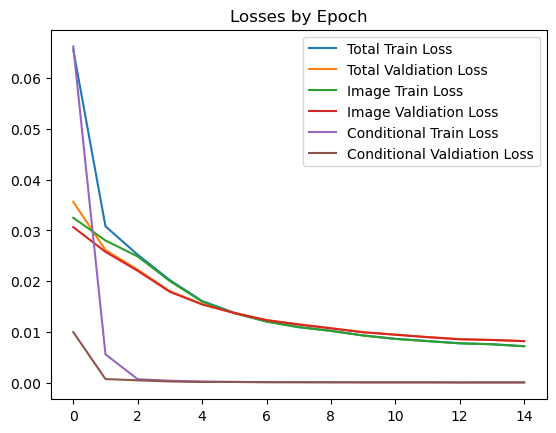

Avg test Loss: 0.0081: 100%|██████████| 23/23 [00:00<00:00, 41.78it/s]


(0.008055455537269945, 0.008042023739898983, 2.6863528783787448e-05)

In [233]:
train_losses = history_cnn['train_losses']
val_losses = history_cnn['val_losses']
train_losses_im = history_cnn['train_losses_im']
val_losses_im = history_cnn['val_losses_im']
train_losses_cond = history_cnn['train_losses_cond']
val_losses_cond = history_cnn['val_losses_cond']
plt.title("Losses by Epoch")
plt.plot(train_losses, label='Total Train Loss')
plt.plot(val_losses, label='Total Valdiation Loss')
plt.plot(train_losses_im, label='Image Train Loss')
plt.plot(val_losses_im, label='Image Valdiation Loss')
plt.plot(train_losses_cond, label='Conditional Train Loss')
plt.plot(val_losses_cond, label='Conditional Valdiation Loss')
plt.legend()
plt.show()

trainer._valid_single_epoch(loader=test_loader_cnn_cond, label='test')


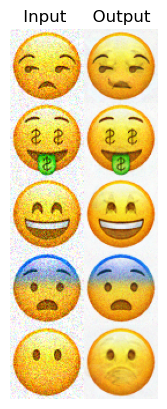

In [236]:
@torch.no_grad()
def plot_input_output(model):
    for batch_X, batch_y in val_loader_cnn:
        test_im = batch_X[:5]
        pred_test_im = model(test_im)[:, :-2].reshape(5,3,64,64)
        final = []
        for i in range(5):
            thing = torch.hstack((torch.rot90(test_im[i], dims=(1,2)), torch.rot90(pred_test_im[i], dims=(1,2)))).permute(2,1,0)
            final.append(thing)

        render = torch.vstack(final)
        plt.imshow(render)
        plt.title(f' Input     Output') # TODO excellent solution! never fix
        plt.axis("off")
        plt.show()
        break

plot_input_output(model=modelCNNcond)

## Save Trained Models For Future Use

In [237]:
import pickle 
# NOTE save model to file system
# path_str = f'./CNNAE.pkl'
# with open(path_str, 'wb') as f:
#     pickle.dump(modelCNN, file=f)
# print(f'Model saved at: {path_str}')


path_str = f'./CNNAE_cond.pkl'
with open(path_str, 'wb') as f:
    pickle.dump(modelCNNcond, file=f)
print(f'Model saved at: {path_str}')

Model saved at: ./CNNAE_cond.pkl


In [ ]:
# NOTE load in model
path_str = f'./CNNAE.pkl'
with open(path, 'rb') as f:
    modelCNN = pickle.load(f)

path_str = f'./CNNAE_con.pkl'
with open(path, 'rb') as f:
    modelCNN = pickle.load(f)